<a href="https://colab.research.google.com/github/julialromero/Collaborative-Problem-Solving/blob/main/learning_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras import layers, Input, Model, optimizers

# Scratchwork

In [3]:
from skimage import io
imag = io.imread('drive/MyDrive/data/RAW/1010-ExpBlock1_RAW.png', as_gray=True)
io.imshow(imag)

FileNotFoundError: ignored

In [ ]:
for filename in os.listdir('drive/MyDrive/data/RAW/')[0:15]:
  imag = io.imread('drive/MyDrive/data/RAW/' + filename, as_gray=True)
  print(imag.shape)

In [ ]:
imgsize = (int(719/2), int(719/2)) 
imag = io.imread('drive/MyDrive/data/RAW/1020-ExpBlock1_RAW.png', as_gray=True)
plt.figure()
io.imshow(imag)
x = image.img_to_array(imag)

#x = tf.keras.preprocessing.image.smart_resize(x, imgsize)
x = np.array(x)
plt.figure()
io.imshow(x.squeeze())
#n = preprocess_input(x)    # preprocess input for Inception v3

### (760, 598, 4)

# Helper Functions

---NOTE---
Resizing the image changes the RP so for now keep it the same size.

In [6]:
# read, preprocess, and scale images to uniform dimension

def extract_image(image_path):
    imag = io.imread(image_path, as_gray=True)
    x = image.img_to_array(imag)

    #x = tf.image.resize(x, imgsize) # TODO: try interpolation = "nearest" instead of default "bilinear"
    
    #n = preprocess_input(x)
    return x

In [7]:
def accuracy(predicted, observed):
    if(len(predicted) != len(observed)):
        print("Error - length of input series is not equal.")
        return np.nan
    
    correct = 0
    for pred, obs in zip(predicted, observed):
        if pred == obs:
            correct += 1
    acc = correct / len(predicted)
    return acc

In [8]:
# Use InceptionV3 model for feature extraction
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(None, None, 3),
    pooling='max',
)

87924736/87910968 [==============================] - 1s 0us/step


In [9]:
def extract_score(filename, outcome_df, score_col="task_score"):
    #  match this file's id/block with task score and return
    groupid, splitname = filename.split("-")
    block = splitname.split("_")[0]
    row = outcome_df.loc[(outcome_df.GROUPID == int(groupid)) & (outcome_df.block == block)]
    if(row.shape[0] != 1):
        print(f"Error -- Number of task scores recorded is not 1 for block {block} and groupid {groupid}.")
        return np.nan
    score = row[score_col].values[0]
    return score

## Load and preprocess data

In [18]:
path332 = '/content/drive/MyDrive/data/CSCI 5922 - Final Project/332x332 - Recurrence_Matrices/RAW/'
path719 = '/content/drive/MyDrive/data/CSCI 5922 - Final Project/719x719 - Recurrence_Matrices/RAW/'
path98 = '/content/drive/MyDrive/data/CSCI 5922 - Final Project/98x98 - Recurrence_Matrices/RAW/'

In [53]:
# CONFIG
path = path98
imgsize = (98, 98)

In [20]:
outcome_df = pd.read_csv("drive/MyDrive/data/team_block_outcomes.csv")

In [21]:
# read data to np arrays
recurrence_plot_list = []
labels = []
for filename in os.listdir(path98):
    # preprocess image
    t = extract_image(path98 + filename)
    
    # get task score
    lab = extract_score(filename, outcome_df, score_col="task_score")
    
    recurrence_plot_list.append(t)
    labels.append(lab)

recurrence_plot_list = np.array(recurrence_plot_list)
labels = np.array(labels)

print(f"Number of samples: {recurrence_plot_list.shape[0]}")

Number of samples: 271


In [22]:
if (recurrence_plot_list.shape[0] == len(np.unique(recurrence_plot_list, axis=0))):
  print("No duplicate samples.")
else:
  print("WARNING - duplicate samples.")

No duplicate samples.


In [33]:
import sklearn
from sklearn.model_selection import train_test_split

# Split into train/test set
X_train, X_test, y_train, y_test = train_test_split(recurrence_plot_list, labels, random_state=11, train_size=0.81)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.78)

In [34]:
print(f"Train #: {X_train.shape[0]}")
print(f"Test #: {X_test.shape[0]}")

Train #: 219
Test #: 52


Let's upsample the minority labels.

(array([76., 32., 36., 14., 28.,  8., 10.,  6.,  5.,  4.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <a list of 10 Patch objects>)

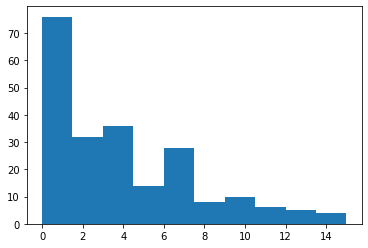

In [50]:
plt.hist(y_train)

In [37]:
df = pd.DataFrame(y_train).reset_index().rename(columns={0:'label'})
df_under = df.loc[df.label >= 7]
df_over = df.loc[df.label < 7]
print(f"Num labels < 7: {df_over.shape[0]}")
print(f"Num labels >= 7: {df_under.shape[0]}")

Num labels < 7: 176
Num labels >= 7: 43


In [41]:
from sklearn.utils import resample
num_to_generate = df_over.shape[0] - df_under.shape[0]
indices_resampled = resample(df_under, n_samples=num_to_generate, random_state=42)

In [48]:
X_train_resampled = np.concatenate([X_train, X_train[indices_resampled['index']]])

y_train_resampled = np.concatenate([y_train, indices_resampled['label']])

(array([76., 32., 36., 14., 56., 28., 43., 22., 24., 21.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <a list of 10 Patch objects>)

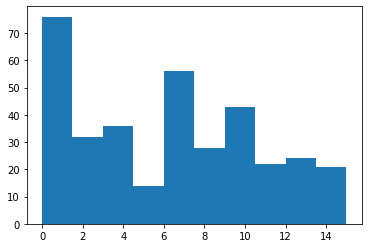

In [52]:
plt.hist(y_train_resampled)

In [89]:
X_train = X_train_resampled
y_train = y_train_resampled.reshape(-1, 1)

# First Model - Classification.
Output layer has 16 nodes with softmax activation.
y labels are one hot encoded, so the neural network learns to get as close to one hot encoded vectors during training. For final accuracy, the outputs are reverse transfomed to labels based on which node has the highest value.

In [ ]:
# Garcia-Ceja paper feeds CNN images with dims 100 x 100 x 4 (width x height x channels)
# Labels are one hot encoded

inputs = Input(shape=(imgsize[0], imgsize[1], 1))
x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(inputs)
x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(512, activation="relu")(x) 
x = layers.Dropout(0.50)(x)
x = layers.Flatten()(x)
out = layers.Dense(16, activation="softmax")(x) 


cc = tf.keras.losses.CategoricalCrossentropy()
adam = keras.optimizers.Adam(learning_rate=0.00001)
model = Model(inputs=inputs, outputs=out)
model.compile(
  optimizer = adam,
  loss= cc, #"mse", #tf.keras.losses.MeanSquaredError(),  
  metrics=['accuracy'],
)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 359, 359, 1)]     0         
                                                                 
 conv2d_204 (Conv2D)         (None, 357, 357, 16)      160       
                                                                 
 conv2d_205 (Conv2D)         (None, 355, 355, 16)      2320      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 177, 177, 16)     0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 177, 177, 16)      0         
                                                                 
 conv2d_206 (Conv2D)         (None, 175, 175, 32)      4640      
                                                           

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', patience=15)
mcp_save = ModelCheckpoint('drive/MyDrive/data/results/.categorical_best_weights.hdf5', save_best_only=True, monitor='val_loss', mode='min')

info1 = model.fit(x=X_train, y=y_train_enc, epochs=70, verbose=True, validation_data=(X_val, y_val_enc), callbacks=[mcp_save, es])

Epoch 1/70
6/6 [==============================] - 15s 3s/step - loss: 2.5051 - accuracy: 0.1189 - val_loss: 2.4984 - val_accuracy: 0.1509
Epoch 2/70
6/6 [==============================] - 2s 262ms/step - loss: 2.4626 - accuracy: 0.1784 - val_loss: 2.5069 - val_accuracy: 0.1321
Epoch 3/70
6/6 [==============================] - 2s 262ms/step - loss: 2.4041 - accuracy: 0.1459 - val_loss: 2.5252 - val_accuracy: 0.2075
Epoch 4/70
6/6 [==============================] - 2s 264ms/step - loss: 2.4027 - accuracy: 0.1297 - val_loss: 2.5383 - val_accuracy: 0.1509
Epoch 5/70
6/6 [==============================] - 2s 264ms/step - loss: 2.3843 - accuracy: 0.1892 - val_loss: 2.5203 - val_accuracy: 0.1509
Epoch 6/70
6/6 [==============================] - 2s 267ms/step - loss: 2.3665 - accuracy: 0.1892 - val_loss: 2.4995 - val_accuracy: 0.1132
Epoch 7/70
6/6 [==============================] - 2s 270ms/step - loss: 2.3742 - accuracy: 0.1838 - val_loss: 2.5150 - val_accuracy: 0.1132
Epoch 8/70
6/6 [======

Text(0.5, 1.0, 'Loss for Softmax, 16 nodes in output')

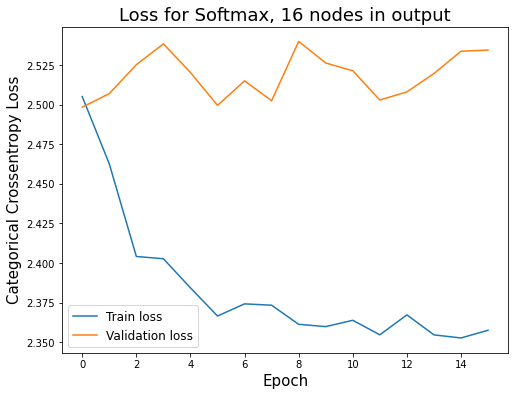

In [ ]:
epochs = [i for i in range(len(info1.history['accuracy']))]
plt.figure(figsize=(8,6))
plt.plot(epochs, info1.history['loss'], label="Train loss")
plt.plot(epochs, info1.history['val_loss'], label="Validation loss")
plt.legend(fontsize=12)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Categorical Crossentropy Loss", fontsize=15)
plt.title("Loss for Softmax, 16 nodes in output", fontsize=18)
#plt.savefig('drive/MyDrive/data/results/Softmax_categorical')

In [ ]:
model.load_weights(filepath = 'drive/MyDrive/data/results/.categorical_best_weights.hdf5')

In [ ]:
# now calculate the actual accuracy
test_predictions = model.predict(X_test)
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)

In [ ]:
final_pred = enc.inverse_transform(test_predictions).squeeze()
final_train_pred = enc.inverse_transform(train_predictions).squeeze()
final_val_pred = enc.inverse_transform(val_predictions).squeeze()

In [ ]:
test_acc = accuracy(final_pred, y_test)
train_acc = accuracy(final_train_pred, y_train)
val_acc = accuracy(final_val_pred, y_val)
print("Classification with softmax")
print("----Results----")
print(f"Size of train set: {y_train.shape[0]}")
print(f"Train acc: {train_acc}")
print(f"----\nSize of validation set: {y_val.shape[0]}")
print(f"Validation acc: {val_acc}")
print(f"----\nSize of test set: {y_test.shape[0]}")
print(f"Test acc: {test_acc}")

Classification with softmax
----Results----
Size of train set: 185
Train acc: 0.1891891891891892
----
Size of validation set: 53
Validation acc: 0.1509433962264151
----
Size of test set: 33
Test acc: 0.2727272727272727


# Now lets try regression
Ideas -- <br>
1) Use tanh activation function (-1, 1). Scale labels to between -1, 1. One issue is that our data is [0, 15].
  - we could scale to (-0.99999, 0.999999). 
  - we could add labels for -1 and 16, then scale to betwen (-1, 1) then remove these fake labels.

<br>
2) sigmoid output ^ same but (0, 1)



In [97]:
# Garcia-Ceja paper feeds CNN images with dims 100 x 100 x 4 (width x height x channels)
# Labels are one hot encoded

inputs = Input(shape=(imgsize[0], imgsize[1], 1))
x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(inputs)
x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.05)(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.05)(x)
x = layers.Dense(512, activation="relu")(x) 
x = layers.Dropout(0.00)(x)
x = layers.Flatten()(x)
out = layers.Dense(1, activation="linear")(x) 

model = Model(inputs=inputs, outputs=out)
model.compile(
  optimizer = "adam",
  loss= "mse", #tf.keras.losses.MeanSquaredError(),  
  metrics=['accuracy'],
)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 98, 98, 1)]       0         
                                                                 
 conv2d_110 (Conv2D)         (None, 96, 96, 16)        160       
                                                                 
 conv2d_111 (Conv2D)         (None, 94, 94, 16)        2320      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 47, 47, 16)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 47, 47, 16)        0         
                                                                 
 conv2d_112 (Conv2D)         (None, 45, 45, 32)        4640      
                                                           

In [82]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import validation_curve

In [ ]:
! pip install scikeras[tensorflow]

In [88]:
es = EarlyStopping(monitor='val_loss', patience=20)
mcp_save = ModelCheckpoint('drive/MyDrive/data/results/.regression_best_weights.hdf5', save_best_only=True, monitor='val_loss', mode='min')

kfold = KFold(n_splits=7)


In [110]:
es = EarlyStopping(monitor='val_loss', patience=10)


fold_num = 1
info_list = []
best_loss = 9999
for train_index, val_index in kfold.split(X_train):
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_num} ...')

  # Split data and fit model
  X_trains, X_vals = X_train[train_index], X_train[val_index]
  y_trains, y_vals = y_train[train_index], y_train[val_index]

  mcp_save = ModelCheckpoint('drive/MyDrive/data/results/.regression_best_weights.hdf5', save_best_only=True, 
                           monitor='val_loss', mode='min', initial_value_threshold=best_loss)
  info_regression = model.fit(x=X_trains, y=y_trains, epochs=150, verbose=0, validation_data=(X_vals, y_vals), callbacks=[mcp_save, es])
  info_list.append(info_regression)

  # Now Evaluate this fold
  test_predictions = np.around(model.predict(X_test))
  train_predictions = np.around(model.predict(X_trains))
  val_predictions = np.around(model.predict(X_vals))
  scores = model.evaluate(X_test, y_test, verbose=0)

  train_acc = accuracy(train_predictions, y_trains)
  val_acc = accuracy(val_predictions, y_vals)
  test_acc = accuracy(test_predictions, y_test)

  print(f'Score for fold {fold_num}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  print(f"Train acc: {train_acc}")
  print(f"Validation acc: {val_acc}")
  print(f"Test acc: {test_acc}")

  # Update the smallest loss encountered thus far
  this_min_loss = min(info_regression.history['val_loss'])
  if this_min_loss < best_loss:
    best_loss = this_min_loss


  fold_num+=1

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 7.6776533126831055; accuracy of 19.23076957464218%
Train acc: 0.5016611295681063
Validation acc: 0.17647058823529413
Test acc: 0.1346153846153846
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 8.630799293518066; accuracy of 15.384615957736969%
Train acc: 0.5514950166112956
Validation acc: 0.43137254901960786
Test acc: 0.09615384615384616
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 8.921356201171875; accuracy of 19.23076957464218%
Train acc: 0.7814569536423841
Validation acc: 0.38
Test acc: 0.09615384615384616
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 8.45914363861084; accuracy of 21.153846383094788%
Train acc: 0.7450331125827815
Vali

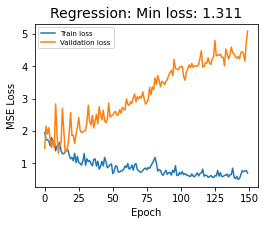

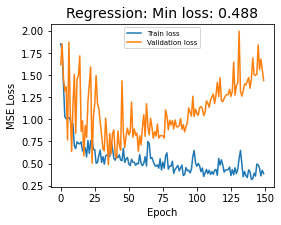

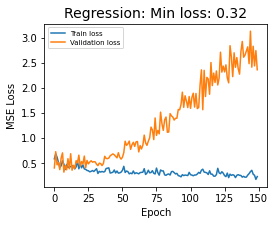

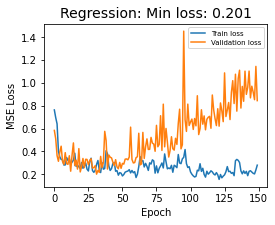

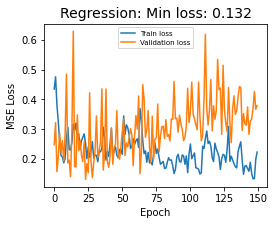

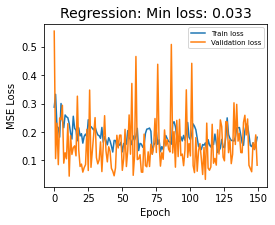

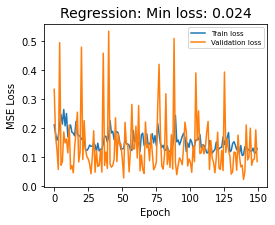

In [111]:
for info_regression in info_list:

  epochs = [i for i in range(len(info_regression.history['accuracy']))]
  plt.figure(figsize=(4,3))
  plt.plot(epochs, info_regression.history['loss'], label="Train loss")
  plt.plot(epochs, info_regression.history['val_loss'], label="Validation loss")
  plt.legend(fontsize=7)
  plt.xlabel("Epoch", fontsize=10)
  plt.ylabel("MSE Loss", fontsize=10)
  plt.title(f"Regression: Min loss: {round(min(info_regression.history['val_loss']), 3)}", fontsize=14)
  #plt.savefig('drive/MyDrive/data/results/Softmax_categorical')

In [112]:
model.load_weights(filepath = 'drive/MyDrive/data/results/.regression_best_weights.hdf5')

In [115]:
# now calculate the actual accuracy
test_predictions = np.around(model.predict(X_test))
train_predictions = np.around(model.predict(X_train))

In [123]:
test_acc = accuracy(test_predictions, y_test)
train_acc = accuracy(train_predictions, y_train)
print("Regression with RAW UNSHUFFLED DATA")
print("----Accuracy----")
print(f"Size of train set: {y_train.shape[0]}")
print(f"Train acc: {train_acc}")
print(f"----\nSize of test set: {y_test.shape[0]}")
print(f"Test acc: {test_acc}")

test_mse = sklearn.metrics.mean_squared_error(y_test, test_predictions)
train_mse = sklearn.metrics.mean_squared_error(y_train, train_predictions)
                                   
print("----MSE----")
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

Regression with RAW UNSHUFFLED DATA
----Accuracy----
Size of train set: 352
Train acc: 0.9318181818181818
----
Size of test set: 52
Test acc: 0.1346153846153846
----MSE----
Train MSE: 0.06818181818181818
Test MSE: 7.134615384615385
